# Who Gets Vaccinated? Machine Learning Predictions of H1N1 and Seasonal Flu Vaccine Uptake





## 1. Business Understanding
The goal of this project is to develop a machine learning model that can predict the likelihood that an individual received the 2009 H1N1 vaccine and the seasonal flu vaccine based on survey responses. These predictions are to be returned as probabilities, not binary classifications. This makes the problem a multi-label probabilistic classification task — with two separate target variables to predict.

By accurately predicting vaccine uptake probabilities, public health stakeholders can better understand the factors influencing vaccine behavior and potentially design targeted interventions to increase vaccination rates among underrepresented or hesitant populations.

A successful model will help:

1. Predict and profile vaccine-hesitant populations.

2. Guide more effective public health messaging.

3. Assist in real-time policy decisions during future outbreaks (e.g., COVID-19, RSV, Monkeypox).

4. Serve as a foundation for equity-based healthcare interventions.




###  Stakeholders: 
The primary stakeholders for this model include:

1. Public health officials and policymakers, such as those working in the CDC or WHO, who need to identify populations at higher risk of remaining unvaccinated.

2. Healthcare providers and outreach programs, who can use this information to target specific groups (e.g., those with low health literacy or without insurance).

3. Researchers in epidemiology and behavioral science, who seek to understand the behavioral and socio-demographic factors influencing vaccine hesitancy.




### Business Goals
Maximize prediction accuracy of vaccine uptake for both H1N1 and seasonal flu vaccines.

Identify key behavioral, attitudinal, and demographic drivers of vaccine behavior.

Inform public health strategy by pinpointing populations less likely to receive vaccines.

Enable resource prioritization, such as focused education or mobile clinics in high-risk groups.

### Key Questions
1. What individual-level characteristics (e.g., age, health status, beliefs, behavior) predict whether someone received the H1N1 or seasonal flu vaccine?

2. Are there groups with disproportionately low vaccine uptake?

3. How do recommendations from healthcare professionals influence vaccine behavior?

4. Can this model help anticipate future vaccine hesitancy for other campaigns?



# 2. Data understanding

Dataset Overview
The data originates from the National 2009 H1N1 Flu Survey, conducted in the United States to understand vaccine behaviors during the H1N1 pandemic. The full dataset includes respondent-level survey responses, capturing demographics, health status, behavioral practices, opinions about vaccines, and employment information.
Source: 2009 National H1N1 Flu Survey (N = ~26,000)

### Vaccine Dataset

| File Name               | Description                                          |
|-------------------------|------------------------------------------------------|
| training_set_features.csv | Input features (n ≈ 26,000 respondents)            |
| training_set_labels.csv   | Target labels for H1N1 and seasonal flu vaccine uptake |
| test_set_features.csv     | Features for test set                              |



### Target Variables
The task is to predict two independent binary variables:

Target Variable	Description
|Target Variable               | Description                                          |
|-------------------------|------------------------------------------------------|
| H1N1_vaccine	1 | received H1N1 vaccine           |
| H1N1 vaccine; 0    | Did not receive |
| Seasonal_vaccine	1     | Received H1N1 vaccine|
|  Seasonal flu vaccine; 0 | Did not receive |


These are modeled separately as a multi-label problem. Some individuals received both vaccines, others only one, and many received neither.

# 3. Data preparation and cleaning

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load the dataset
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv("test_set_features.csv")


In [4]:
# Initial exploration
print(train_features.shape)
print(train_labels.shape)

# Display the first few rows of the dataset
print(train_features.head())
print(train_labels.head())

print(train_features.info())



(26707, 36)
(26707, 3)
   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                     

In [5]:
# Check for missing values
train_features.isnull().sum().sort_values(ascending=False).head(10)

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [6]:
# Merge labels
data = train_features.merge(train_labels, on="respondent_id")

# check merged data
print(data.info())

#drop respondent_id
data = data.drop(columns=['respondent_id'])

# Check for missing values
data.isnull().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [7]:
# clean the missing values
def clean_missing_values(data):
    # Fill missing values for categorical columns with mode
    for col in data.select_dtypes(include=['object']).columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
    
    # Fill missing values for numerical columns with mean
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        data[col].fillna(data[col].mean(), inplace=True)
    
    return data

data = clean_missing_values(data)

# Check the cleaned data
print(data.head(5))

# describe the data
data.describe(include='all')


   h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0           1.0             0.0                        0.0   
1           3.0             2.0                        0.0   
2           1.0             1.0                        0.0   
3           1.0             1.0                        0.0   
4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,...,26707,26707,26707,26707,26707.000000,26707.000000,26707,26707,26707.000000,26707.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,10,3,NaN,NaN,21,23,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Own,Employed,lzgpxyit,"MSA, Not Principle City",NaN,NaN,fcxhlnwr,xtkaffoo,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20778,15023,4297,11645,NaN,NaN,15798,15248,NaN,NaN
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.358640,0.337315,0.677264,0.220312,...,NaN,NaN,NaN,NaN,0.886499,0.534583,NaN,NaN,0.212454,0.465608
std,0.908741,0.616805,0.215258,0.444473,0.253339,0.379150,0.478828,0.472076,0.466410,0.397351,...,NaN,NaN,NaN,NaN,0.749901,0.923836,NaN,NaN,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.220312,...,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,1.000000


In [8]:
data.columns

print(data.dtypes)



h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

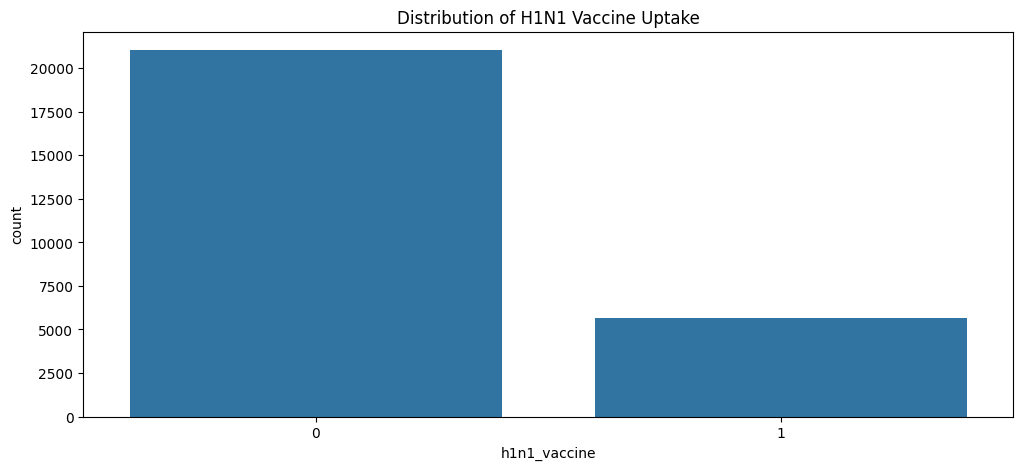

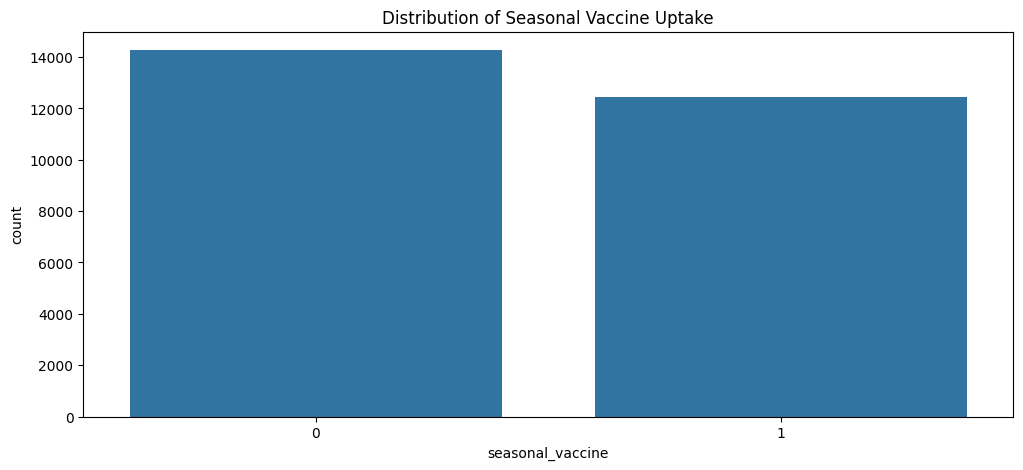

In [9]:
# target variable analysis
data['h1n1_vaccine'].value_counts(normalize=True)
data['seasonal_vaccine'].value_counts(normalize=True)

# visualize target variable distribution
plt.figure(figsize=(12, 5)) 
sns.countplot(x='h1n1_vaccine', data=data)
plt.title('Distribution of H1N1 Vaccine Uptake')    
plt.show()
plt.figure(figsize=(12, 5))
sns.countplot(x='seasonal_vaccine', data=data)
plt.title('Distribution of Seasonal Vaccine Uptake')
plt.show()




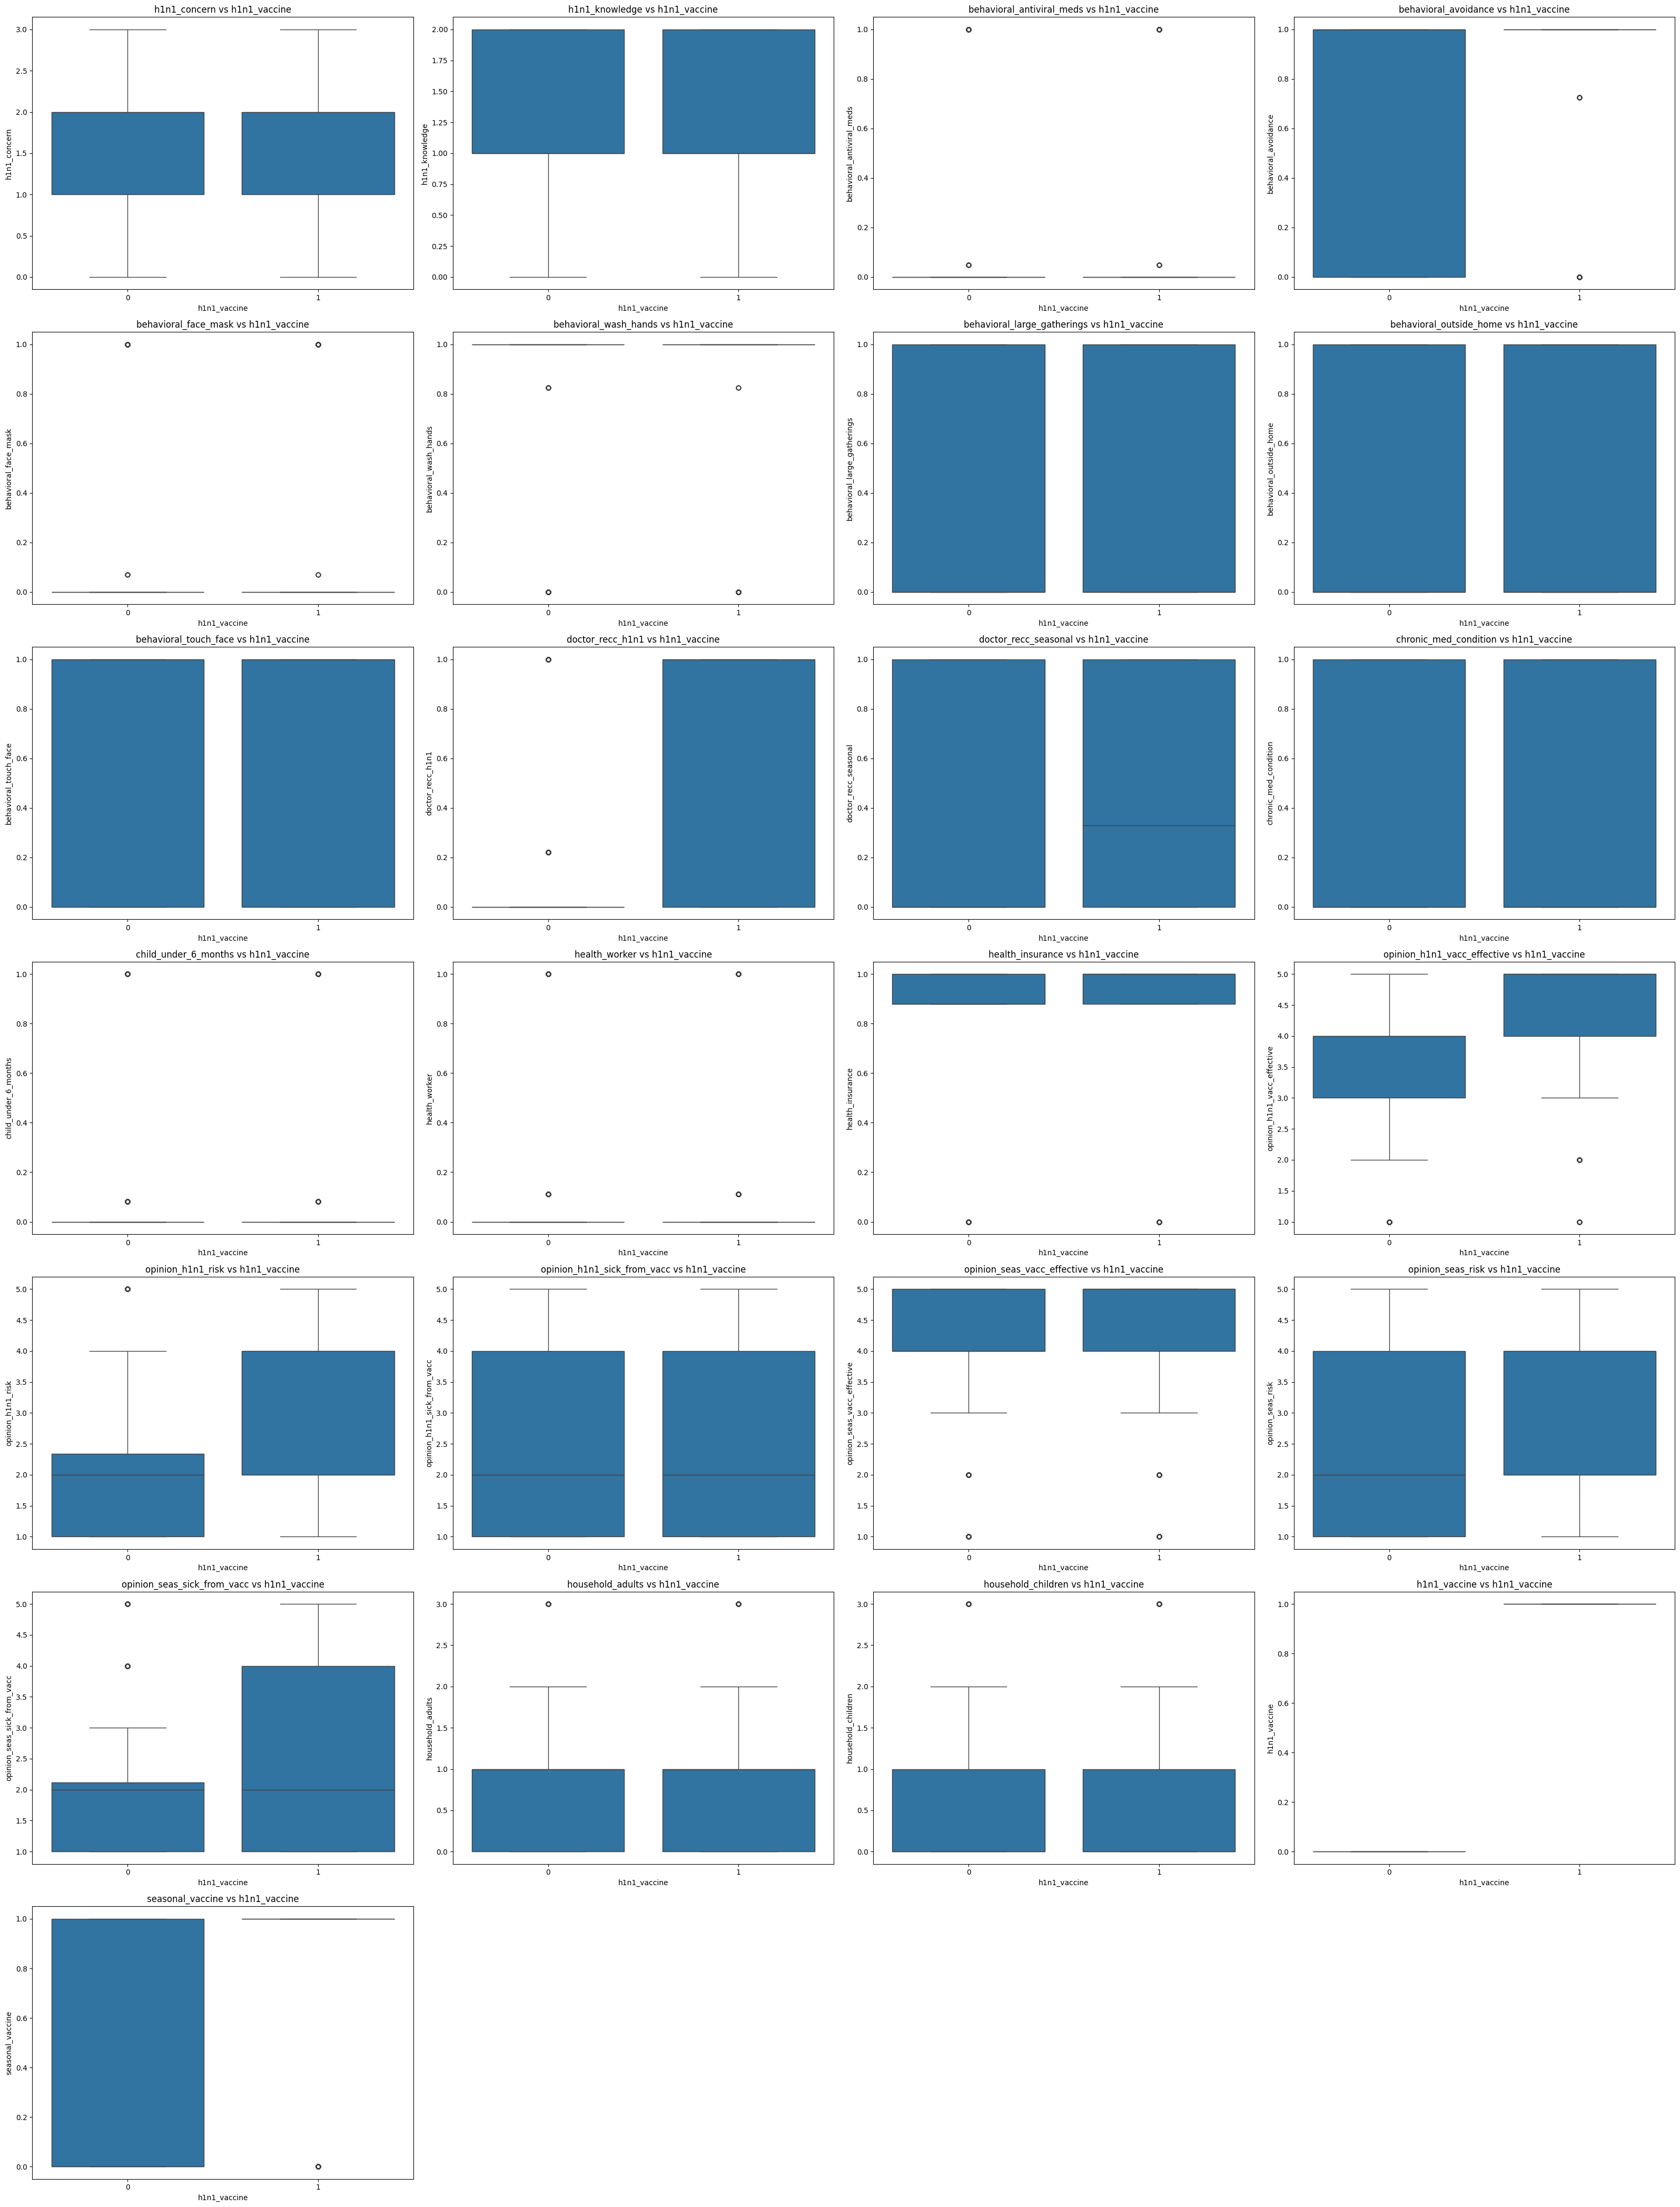

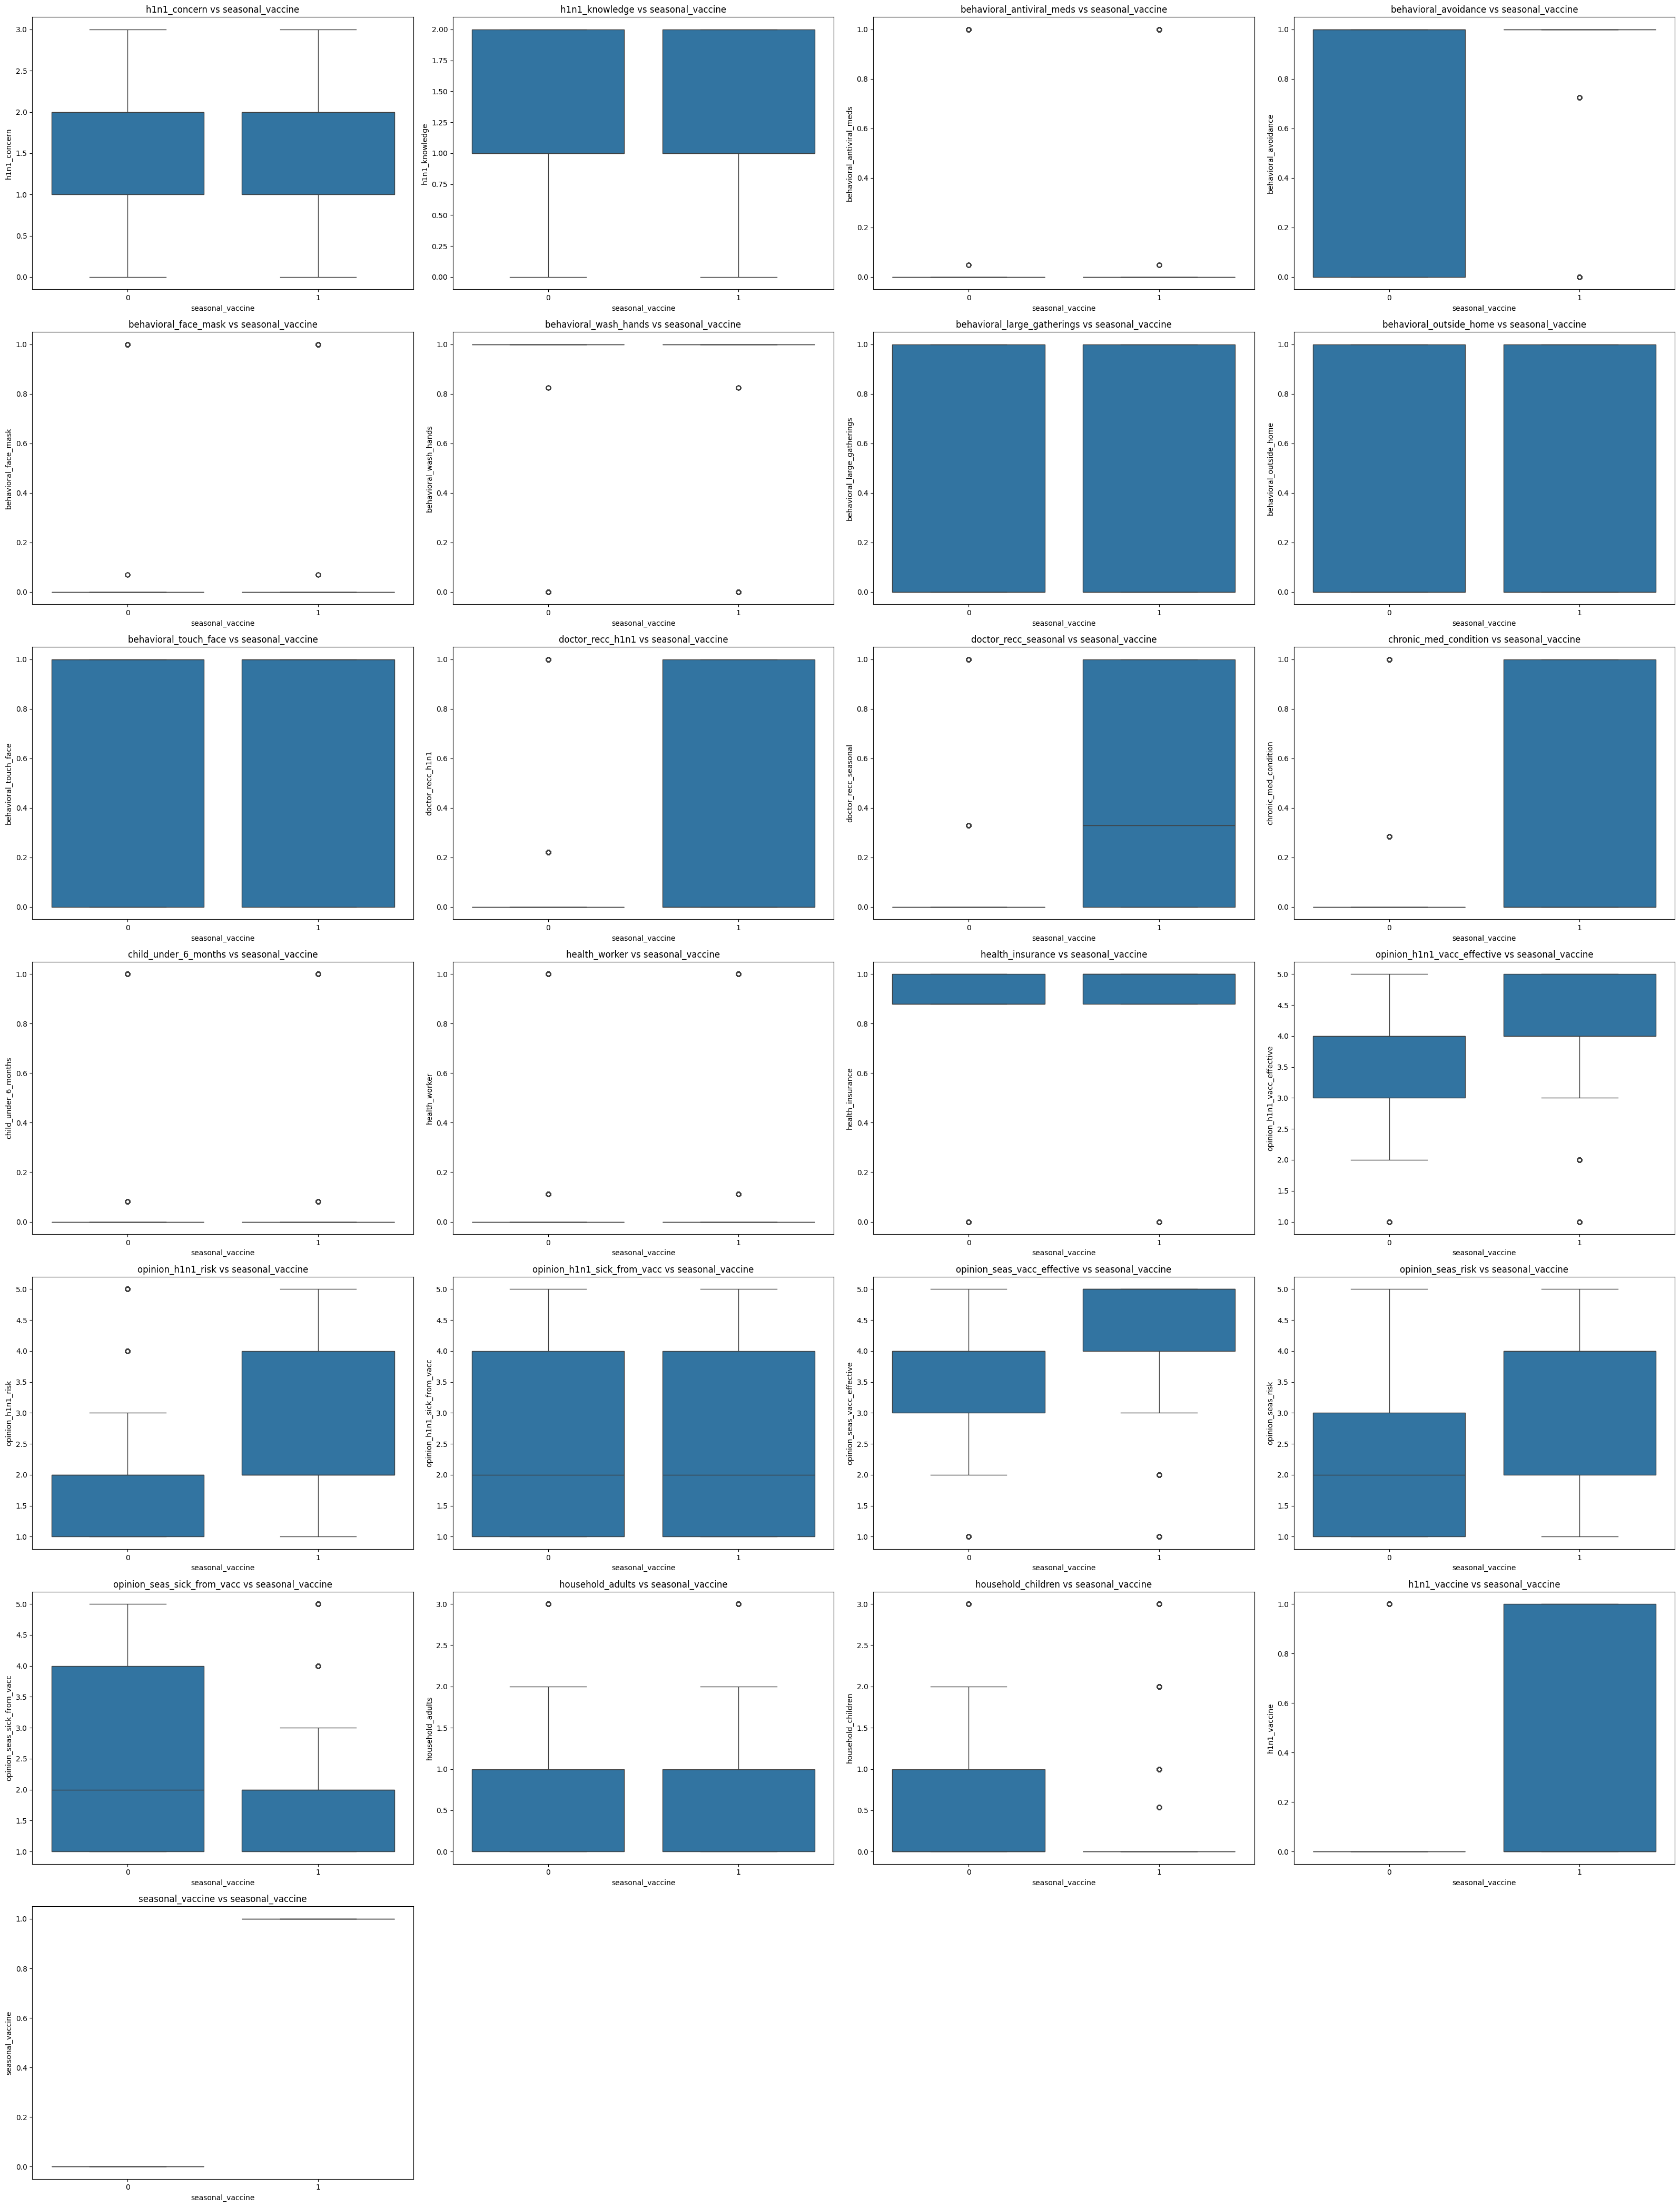

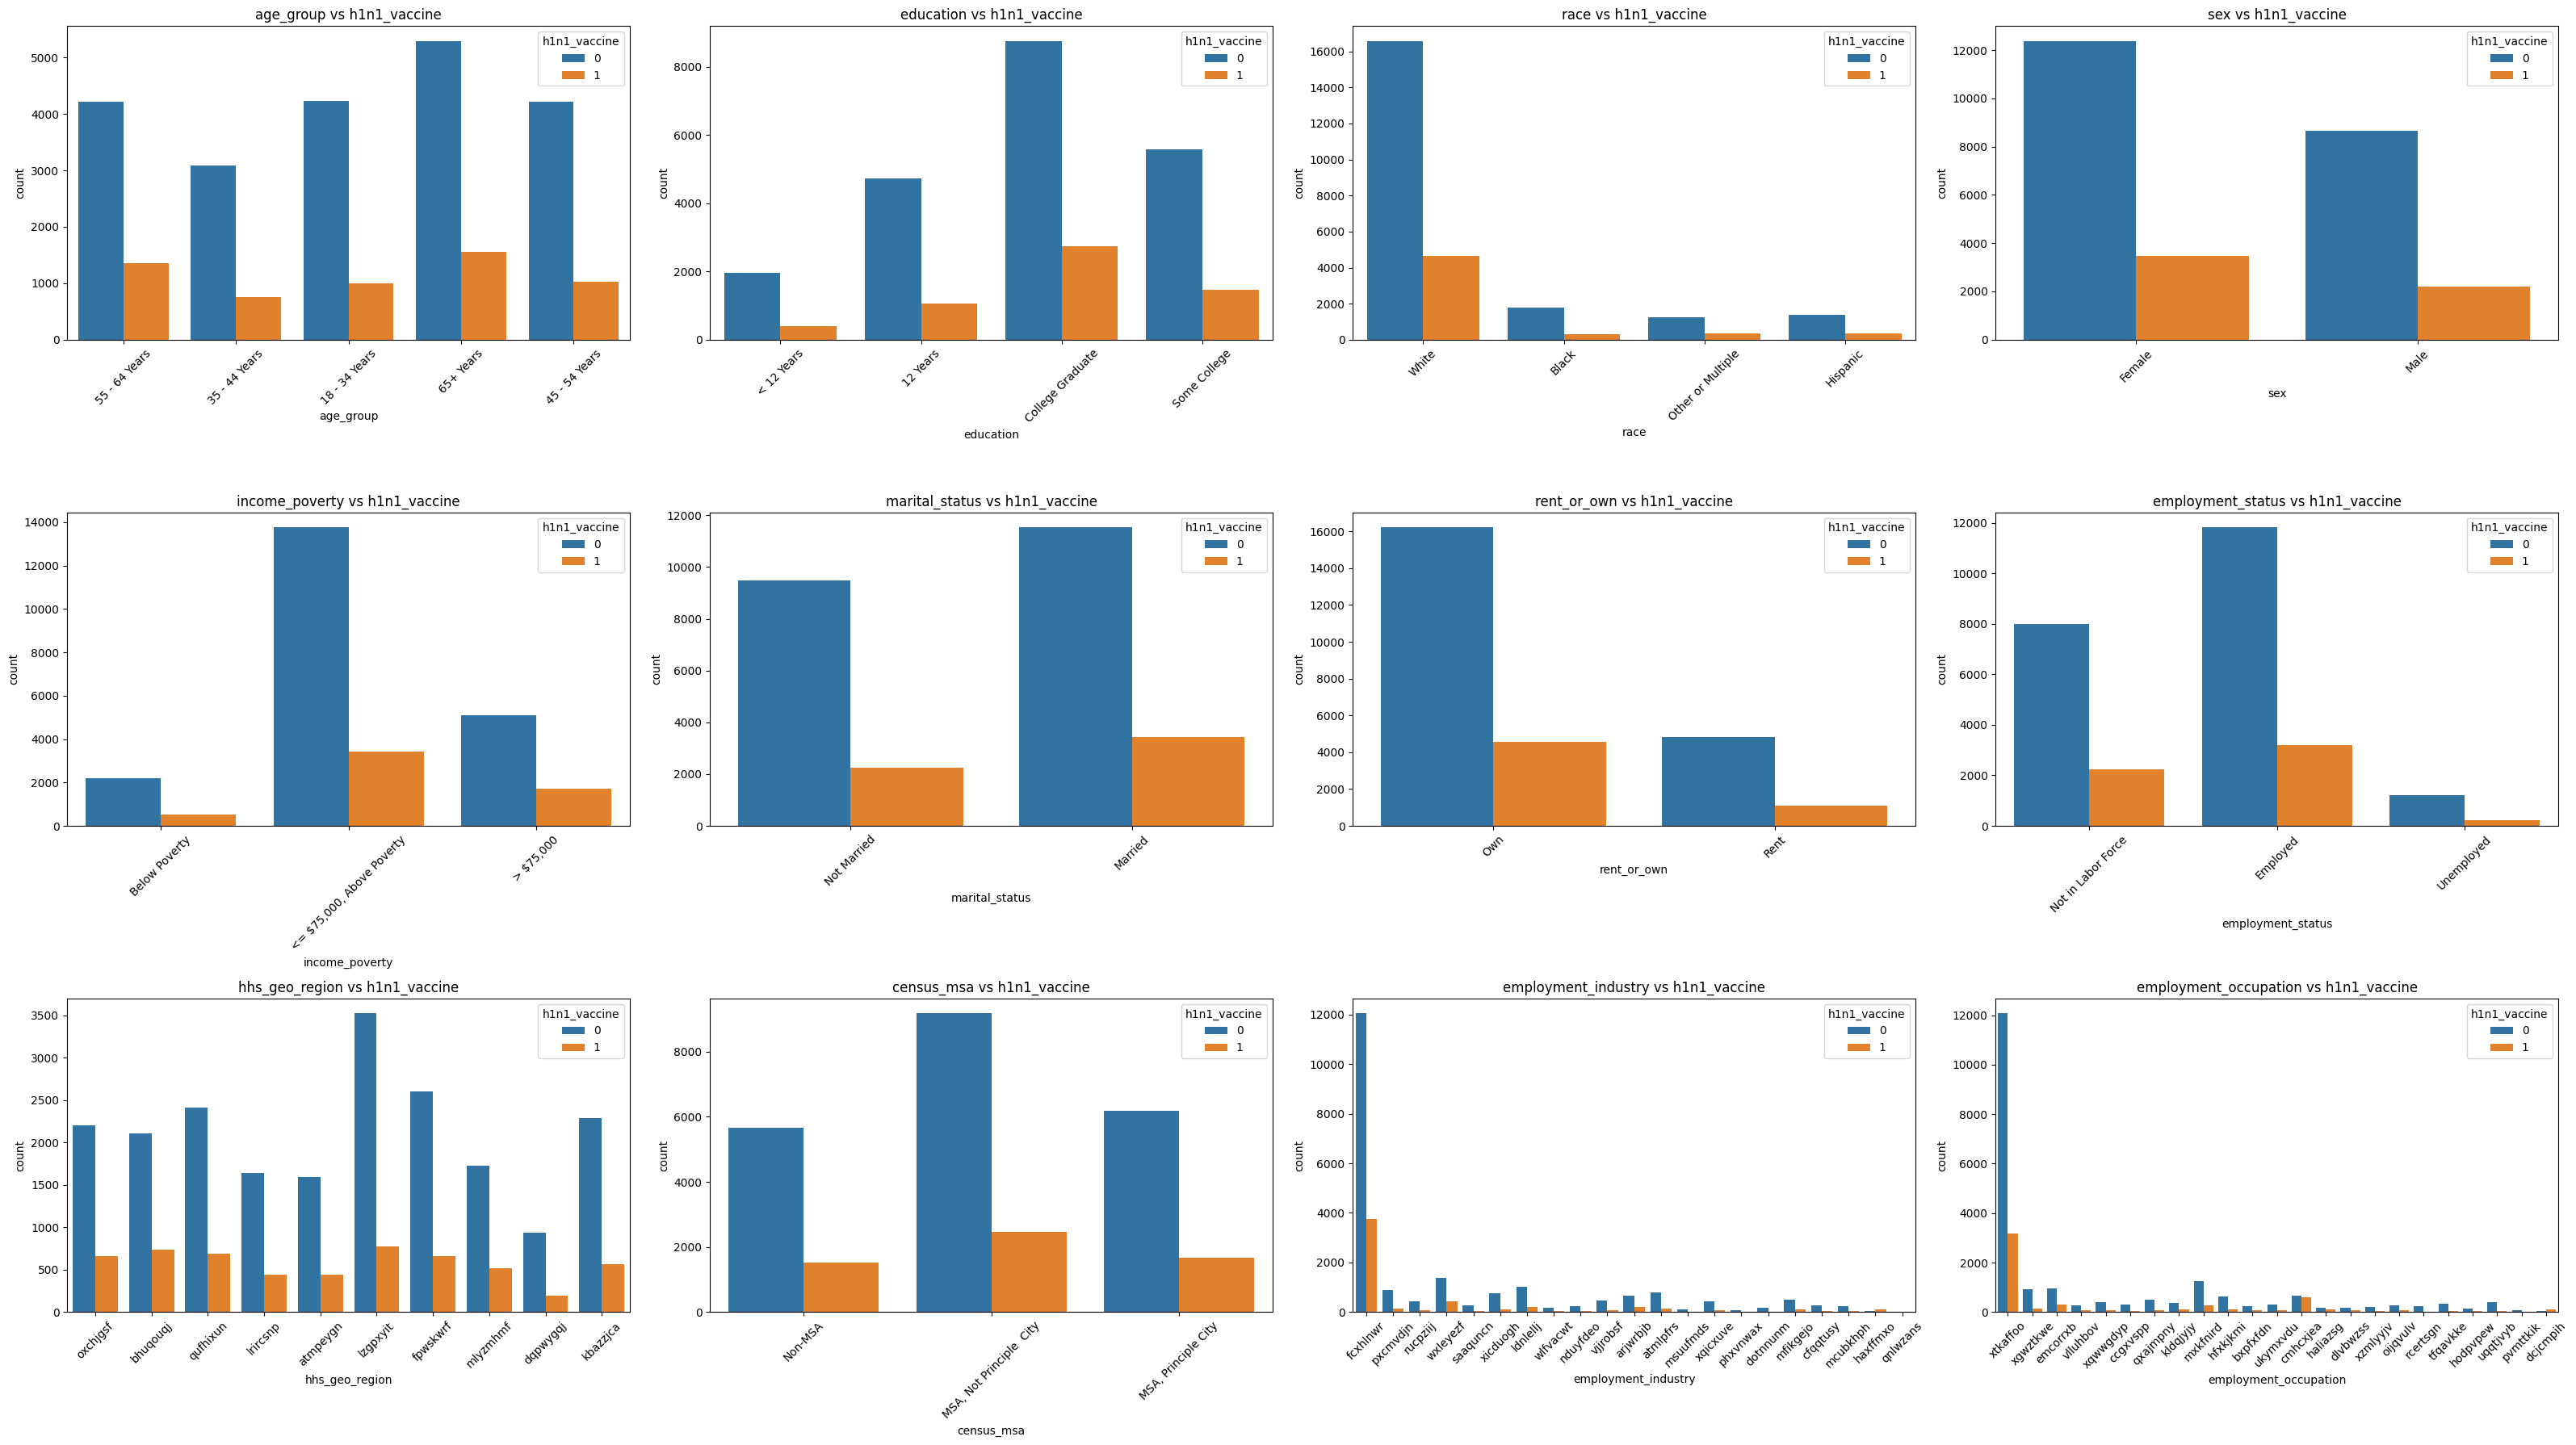

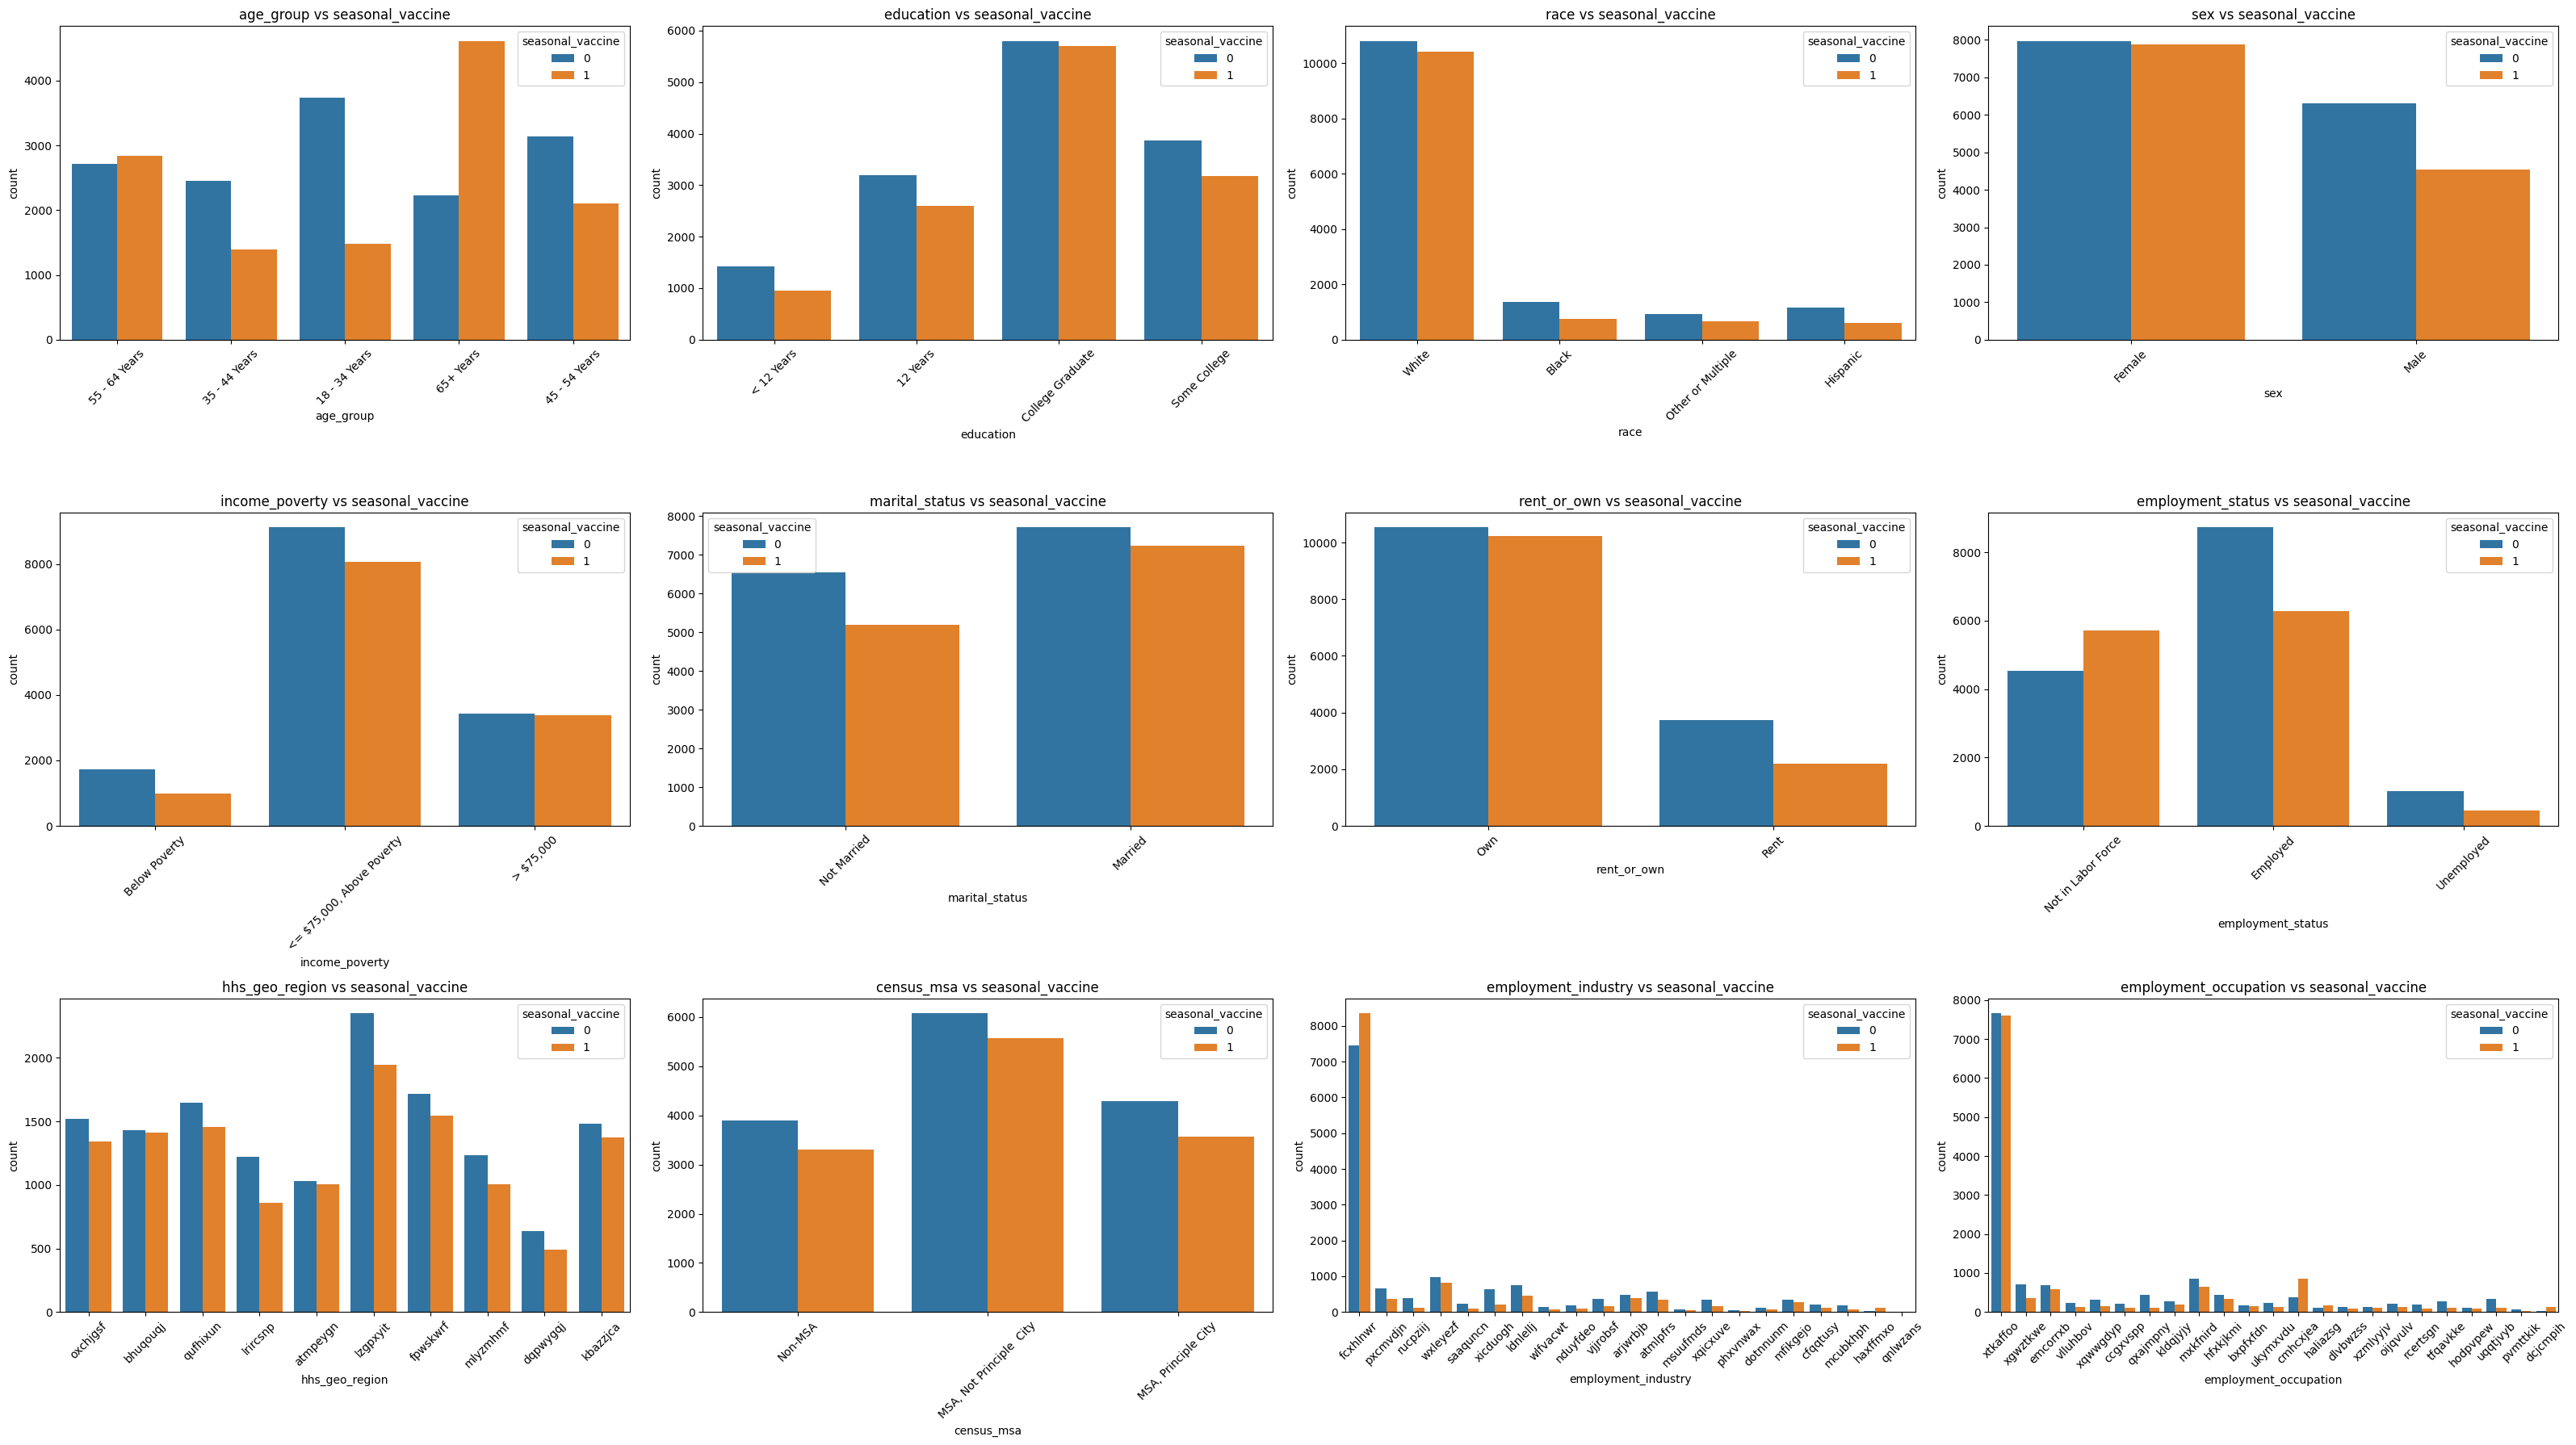

In [10]:
# target variables vs features
#numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
def plot_numerical_features_vs_target(target, features, data, n_cols=4):
    n_rows = (len(features) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 8, n_rows * 6))
    
    for i, col in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=target, y=col, data=data)
        plt.title(f'{col} vs {target}')
        plt.tight_layout()
    
    plt.show()
plot_numerical_features_vs_target('h1n1_vaccine', numerical_features, data)
plot_numerical_features_vs_target('seasonal_vaccine', numerical_features, data)
def plot_categorical_features_vs_target(target, features, data, n_cols=4):
    n_rows = (len(features) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 8, n_rows * 6))
    
    for i, col in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(x=col, hue=target, data=data)
        plt.title(f'{col} vs {target}')
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    plt.show()
plot_categorical_features_vs_target('h1n1_vaccine', categorical_features, data)
plot_categorical_features_vs_target('seasonal_vaccine', categorical_features, data)

In [14]:
# Convert categorical features to numerical

def encode_mixed_categorical_features(data, ordinal_mappings):
    # Copy the data to avoid modifying the original
    data = data.copy()

    # Identify all object-type categorical columns
    all_categoricals = data.select_dtypes(include=['object']).columns.tolist()

    # Identify ordinal and nominal columns
    ordinal_cols = list(ordinal_mappings.keys())
    nominal_cols = [col for col in all_categoricals if col not in ordinal_cols]

    # 1. Apply ordinal encoding manually using mapping
    for col, mapping in ordinal_mappings.items():
        if col in data.columns:
            data[col] = data[col].map(mapping)

    # 2. Handle missing values and OneHotEncoding for nominal variables
    if nominal_cols:
        # Pipeline for nominal (non-ordinal) features
        nominal_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ])

        # ColumnTransformer: apply nominal_pipeline only to nominal columns
        transformer = ColumnTransformer(
            transformers=[
                ('nom', nominal_pipeline, nominal_cols)
            ],
            remainder='passthrough'  # Keep numeric + ordinal columns
        )

        # Fit and transform the data
        data_transformed = transformer.fit_transform(data)

        # Get column names
        encoded_cols = transformer.named_transformers_['nom']['onehot'].get_feature_names_out(nominal_cols)
        remainder_cols = [col for col in data.columns if col not in nominal_cols]
        final_columns = list(encoded_cols) + remainder_cols

        # Create the final DataFrame
        data_encoded = pd.DataFrame(data_transformed, columns=final_columns)
    else:
        # If no nominal features, just return numeric + ordinal as is
        data_encoded = data

    return data_encoded


In [15]:
ordinal_mappings = {
    'income_poverty': {
        'Less than $10,000': 1,
        '$10,000 - $14,999': 2,
        '$15,000 - $19,999': 3,
        '$20,000 - $24,999': 4,
        '$25,000 - $34,999': 5,
        '$35,000 - $49,999': 6,
        '$50,000 - $74,999': 7,
        '$75,000 - $99,999': 8,
        '$100,000 or more': 9,
        'Prefer not to answer': 10
    },
    'employment_status': {
        'Employed for wages': 1,
        'Self-employed': 2,
        'Out of work for more than a year': 3,
        'Out of work for less than a year': 4,
        'A homemaker': 5,
        'Student': 6,
        'Retired': 7,
        'Unable to work': 8,
        'Prefer not to answer': 9
    },
    'marital_status': {
        'Married': 1,
        'Living with a partner': 2,
        'Divorced': 3,
        'Widowed': 4,
        'Separated': 5,
        'Never married': 6,
        'Domestic partnership': 7,
        'Prefer not to answer': 8
    },
    'rent_or_own': {
        'Rent': 1,
        'Own': 2,
        'Other': 3,
        'Prefer not to answer': 4
    },
    'employment_industry': {
        'Agriculture, forestry, fishing and hunting': 1,
        'Mining, quarrying, oil and gas extraction': 2,
        'Utilities': 3,
        'Construction': 4,
        'Manufacturing': 5,
        'Wholesale trade': 6,
        'Retail trade': 7,
        'Transportation and warehousing': 8,
        'Information': 9,
        'Finance and insurance': 10,
        'Real estate and rental and leasing': 11,
        'Professional, scientific, and technical services': 12,
        'Management of companies and enterprises': 13,
        'Administrative and support and waste management services': 14,
        'Educational services (private)': 15,
        'Health care and social assistance': 16,
        'Arts, entertainment, and recreation': 17,
        'Accommodation and food services': 18,
        'Other services (except public administration)': 19,
        'Public administration': 20
    }
}

data_encoded = encode_mixed_categorical_features(data, ordinal_mappings)

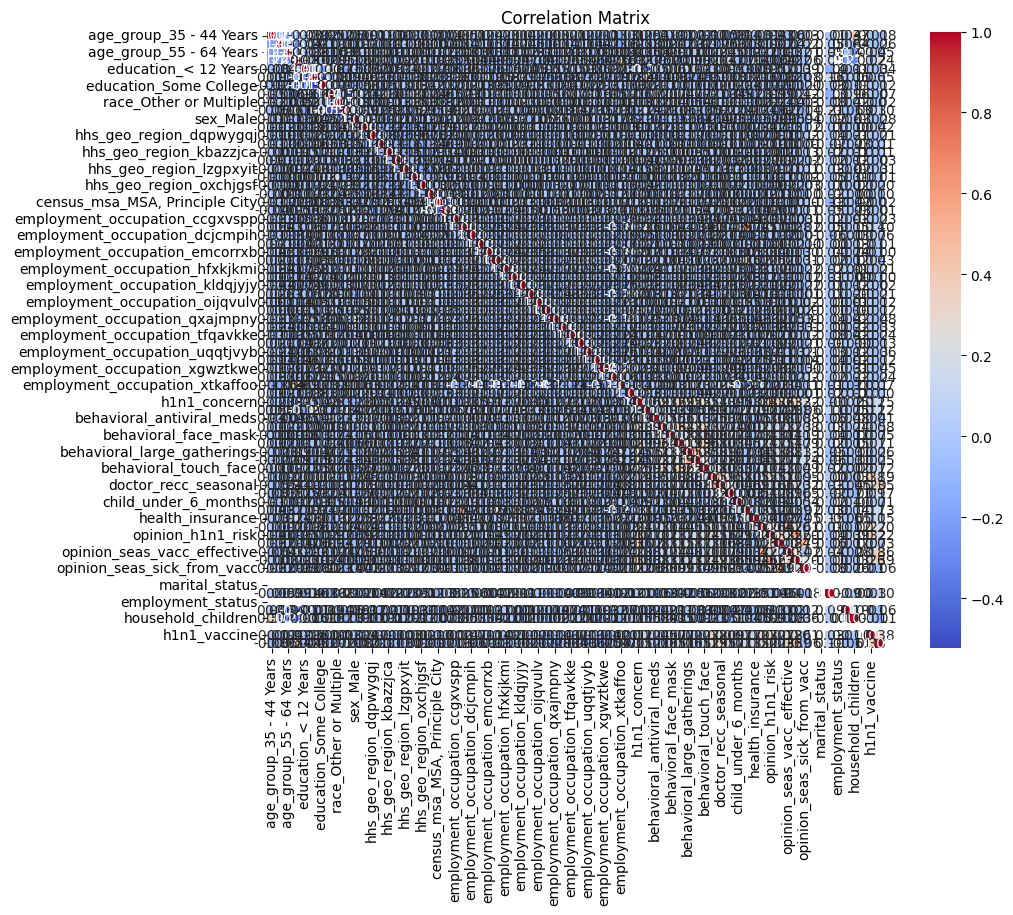

In [16]:
# check for correlation
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


In [17]:
data_encoded.describe()

,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,...,opinion_seas_sick_from_vacc,income_poverty,marital_status,rent_or_own,employment_status,household_adults,household_children,employment_industry,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,...,26707.000000,0.0,14963.0,26707.000000,0.0,26707.000000,26707.000000,0.0,26707.000000,26707.000000
mean,0.144082,0.196128,0.208297,0.256225,0.088479,0.430748,0.263714,0.065713,0.060359,0.794623,...,2.118112,NaN,1.0,1.777998,NaN,0.886499,0.534583,NaN,0.212454,0.465608
std,0.351180,0.397074,0.406098,0.436556,0.283995,0.495190,0.440654,0.247785,0.238155,0.403984,...,1.319480,NaN,0.0,0.415600,NaN,0.749901,0.923836,NaN,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,NaN,1.0,1.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,NaN,1.0,2.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,NaN,1.0,2.000000,NaN,1.000000,0.000000,NaN,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,2.118112,NaN,1.0,2.000000,NaN,1.000000,1.000000,NaN,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,NaN,1.0,2.000000,NaN,3.000000,3.000000,NaN,1.000000,1.000000


In [18]:
# Split the data into training and testing sets
X = data_encoded.drop(columns=['seasonal_vaccine', 'h1n1_vaccine'])
y = data_encoded[['seasonal_vaccine', 'h1n1_vaccine']]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# fill missing values
imputer = SimpleImputer(strategy='mean')  
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [20]:
# scale the data
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Check the shapes of the training and testing sets
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (21365, 69)
X_test_scaled shape: (5342, 69)


# 4. Fit the Model

In [21]:
# Fit Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
# Fit the model
logistic_model.fit(X_train_scaled, y_train)



ValueError: y should be a 1d array, got an array of shape (21365, 2) instead.